In [14]:
from pathlib import Path 
import sys 
sys.path.append(str(Path.cwd().parent))

In [15]:
from utils import predictors, data_loading as dl
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
MAX_PLOT_HORIZON = 500
MAX_PLOT_TRAIN = 100

In [17]:
def plot_predictions(y_train, y_test, y_hat_test):
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])
    sns.lineplot(y=y_train, x=xrange_train, label="train")
    sns.lineplot(y=y_test, x=xrange_test, label="test")
    if y_hat_test is not None:
        sns.lineplot(y=y_hat_test, x=xrange_test, label="prediction")
    # plot vertical dotted line
    plt.axvline(x=y_train.shape[0], linestyle="--", color="black")
    plt.legend()

In [18]:
def calculate_rmse(y_test, y_hat_test):
    se = (y_hat_test - y_test) ** 2
    predicted_days = np.arange(1, se.shape[0]+1)
    rmse = np.sqrt(np.cumsum(se) / predicted_days)

    for h in [10, 50, 100, 200, 300, 1000, y_test.shape[0]]:
        if h > y_test.shape[0]:
            continue
        print(f"{h} steps horizon - rmse = {round(rmse[h-1], 4)}")

    sns.lineplot(y=rmse, x=predicted_days, label="rmse")

# Datasets

In [19]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE)

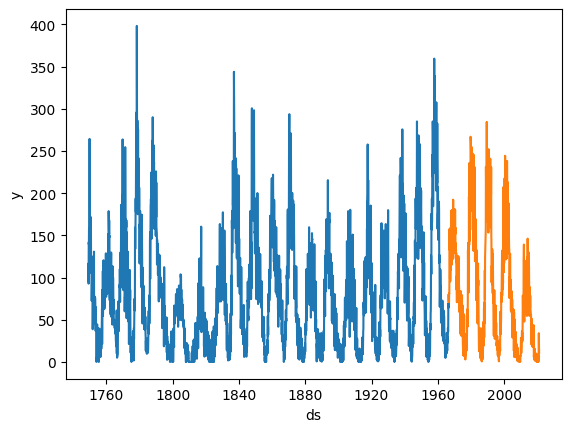

In [7]:
sns.lineplot(data=sunspots.train_df, x="ds", y="y")
sns.lineplot(data=sunspots.val_df, x="ds", y="y")
plt.show()

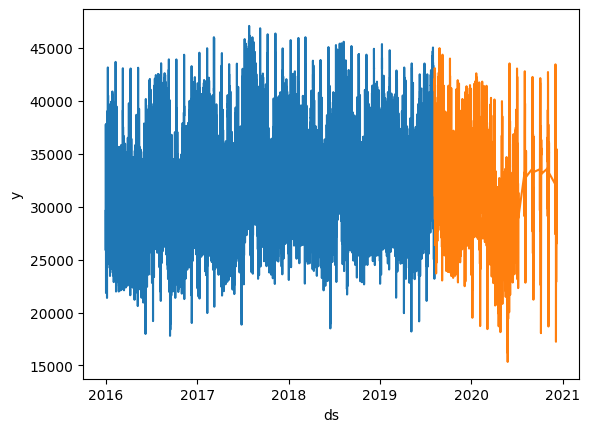

In [8]:
sns.lineplot(data=electricity.train_df, x="ds", y="y")
sns.lineplot(data=electricity.val_df, x="ds", y="y")
plt.show()

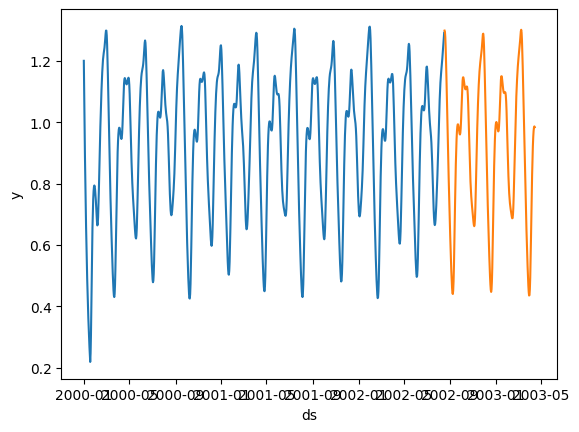

In [9]:
sns.lineplot(data=mackey_glass.train_df, x="ds", y="y")
sns.lineplot(data=mackey_glass.val_df, x="ds", y="y")
plt.show()

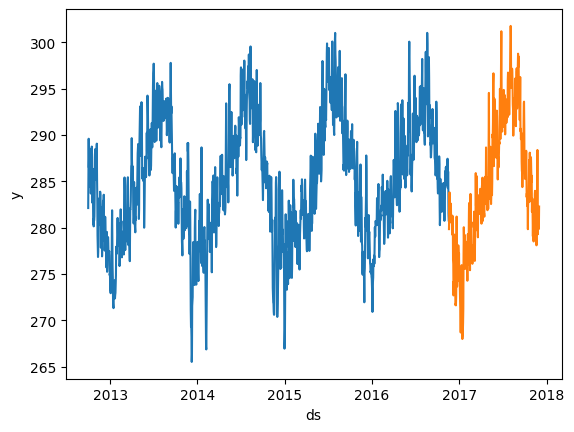

In [10]:
sns.lineplot(data=temperature.train_df, x="ds", y="y")
sns.lineplot(data=temperature.val_df, x="ds", y="y")
plt.show()

# Forecasting with Prophet

## Train model

In [11]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
prophet_params = {
    dl.DATASET.SUNSPOTS: {
        "seasonality_mode": "multiplicative",
        "daily_seasonality": False,
        "weekly_seasonality": False,
        "custom_seasonality": int(10.8 * 365),
    },
    dl.DATASET.ELECTRICITY: {
        "changepoint_prior_scale": 0.01,
        "seasonality_prior_scale": 0.01,
        "seasonality_mode": "additive",
    },
    dl.DATASET.MACKEY_GLASS: {
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 10.0,
        "seasonality_mode": "multiplicative",
        "custom_seasonality": 100,
    },
    dl.DATASET.TEMPERATURE: {},
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = prophet_params[dataset.name]
    model = predictors.ProphetPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612, 2)


18:22:05 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing


DATASET.ELECTRICITY
(31564, 2)


18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1] done processing
18:22:15 - cmdstanpy - INFO - Chain [1] start processing


DATASET.MACKEY_GLASS
(960, 2)


18:22:16 - cmdstanpy - INFO - Chain [1] done processing
18:22:16 - cmdstanpy - INFO - Chain [1] start processing


DATASET.TEMPERATURE
(1509, 2)


18:22:17 - cmdstanpy - INFO - Chain [1] done processing


## Evaluate model

DATASET.SUNSPOTS


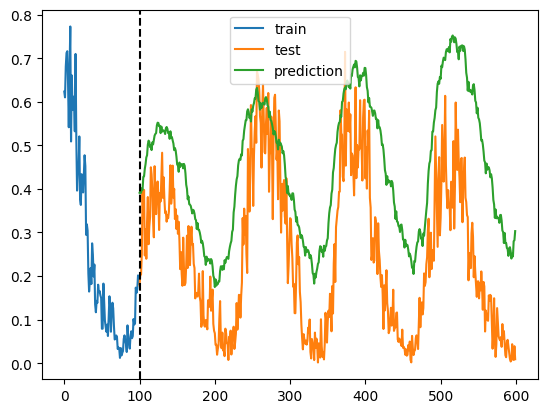

10 steps horizon - rmse = 0.1629
50 steps horizon - rmse = 0.1559
100 steps horizon - rmse = 0.1546
200 steps horizon - rmse = 0.1664
300 steps horizon - rmse = 0.1726
653 steps horizon - rmse = 0.2926


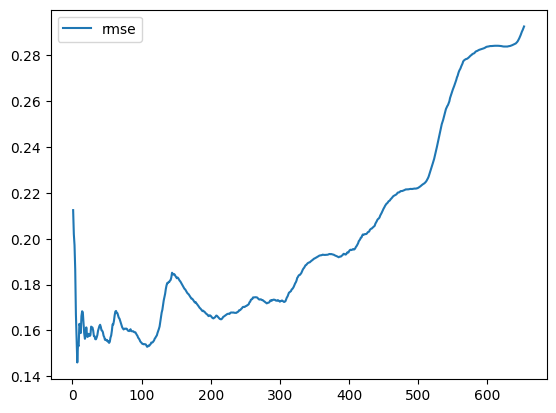


******************************

DATASET.ELECTRICITY


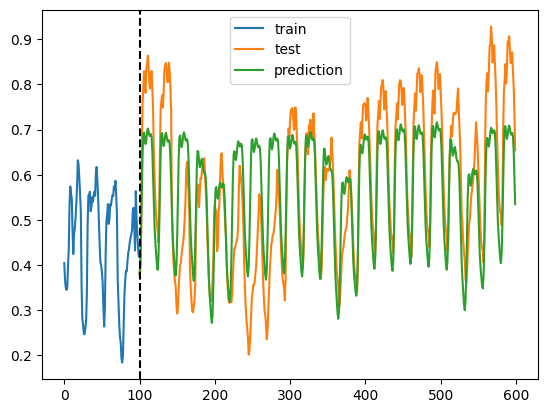

10 steps horizon - rmse = 0.1015
50 steps horizon - rmse = 0.112
100 steps horizon - rmse = 0.1211
200 steps horizon - rmse = 0.1402
300 steps horizon - rmse = 0.1193
1000 steps horizon - rmse = 0.1193
7891 steps horizon - rmse = 0.1344


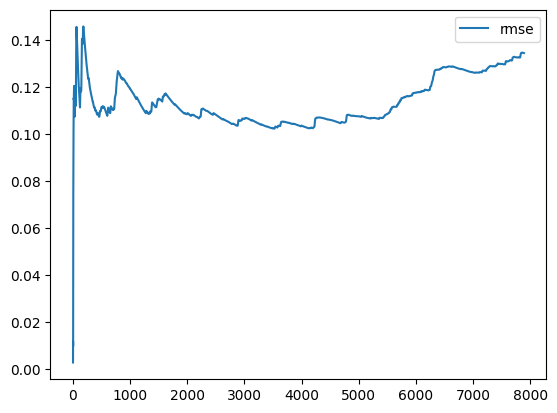


******************************

DATASET.MACKEY_GLASS


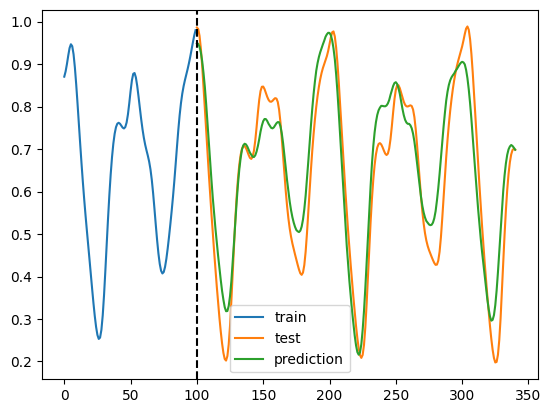

10 steps horizon - rmse = 0.0464
50 steps horizon - rmse = 0.0683
100 steps horizon - rmse = 0.0726
200 steps horizon - rmse = 0.0759
241 steps horizon - rmse = 0.0829


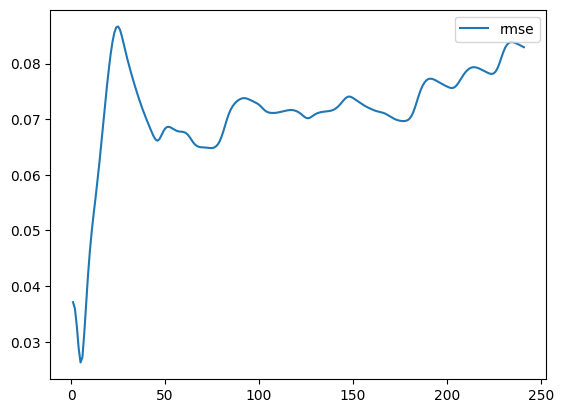


******************************

DATASET.TEMPERATURE


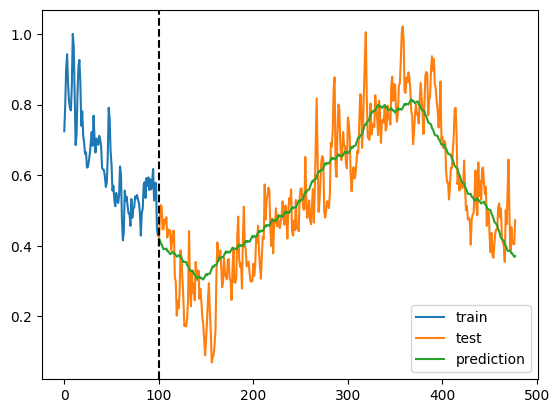

10 steps horizon - rmse = 0.0736
50 steps horizon - rmse = 0.0958
100 steps horizon - rmse = 0.1021
200 steps horizon - rmse = 0.0905
300 steps horizon - rmse = 0.0905
378 steps horizon - rmse = 0.0876


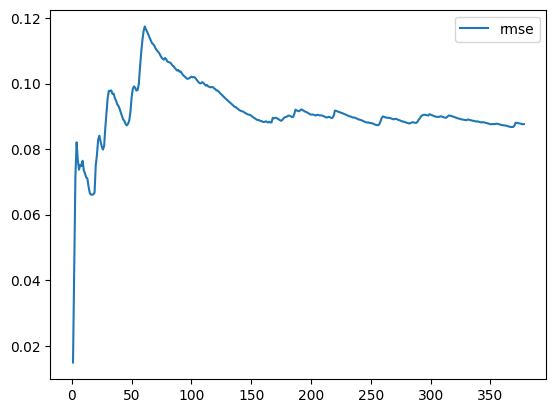


******************************



In [12]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(dataset.df_val[["ds"]])

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

# Forecasting with ARIMA

## Train model

In [13]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
arima_params = {
    dl.DATASET.SUNSPOTS: {
        "order": (5, 0, 5),
    },
    dl.DATASET.ELECTRICITY: {
        "order": (3, 0, 5),
    },
    dl.DATASET.MACKEY_GLASS: {
        "order": (5, 0, 5),
    },
    dl.DATASET.TEMPERATURE: {
        "order": (5, 0, 5),
    },
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    X_train = df_train.y.values
    print(X_train.shape)
    params = arima_params[dataset.name]
    model = predictors.SARIMAPredictor(**params)
    model.fit(X_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DATASET.ELECTRICITY
(31564,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DATASET.MACKEY_GLASS
(960,)
DATASET.TEMPERATURE
(1509,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluate model

DATASET.SUNSPOTS


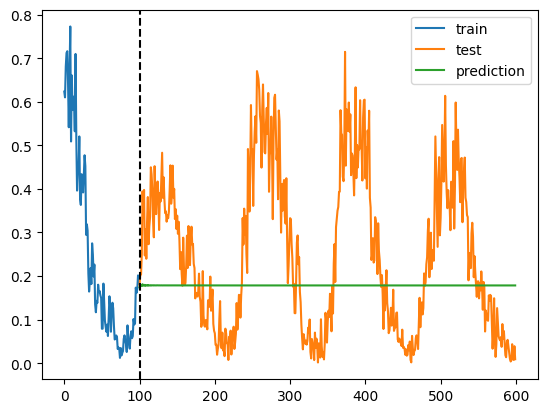

10 steps horizon - rmse = 0.1223
50 steps horizon - rmse = 0.1879
100 steps horizon - rmse = 0.1434
200 steps horizon - rmse = 0.2056
300 steps horizon - rmse = 0.2108
653 steps horizon - rmse = 0.1784


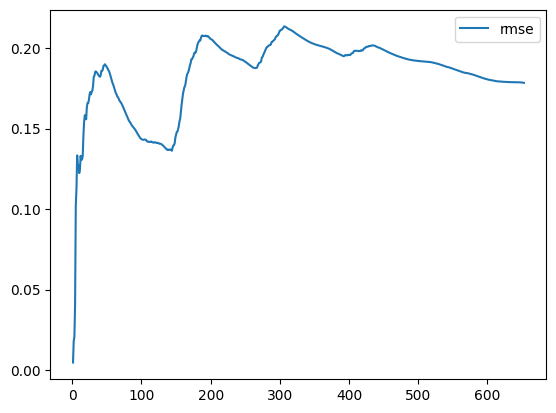


******************************

DATASET.ELECTRICITY


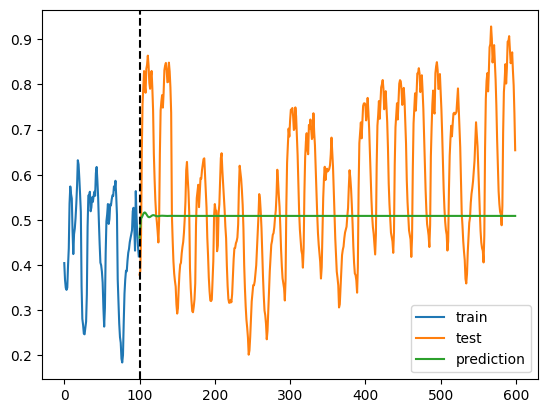

10 steps horizon - rmse = 0.2302
50 steps horizon - rmse = 0.2378
100 steps horizon - rmse = 0.1892
200 steps horizon - rmse = 0.165
300 steps horizon - rmse = 0.1569
1000 steps horizon - rmse = 0.1739
7891 steps horizon - rmse = 0.1796


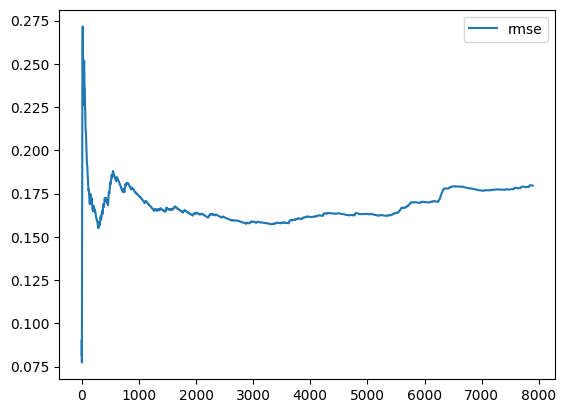


******************************

DATASET.MACKEY_GLASS


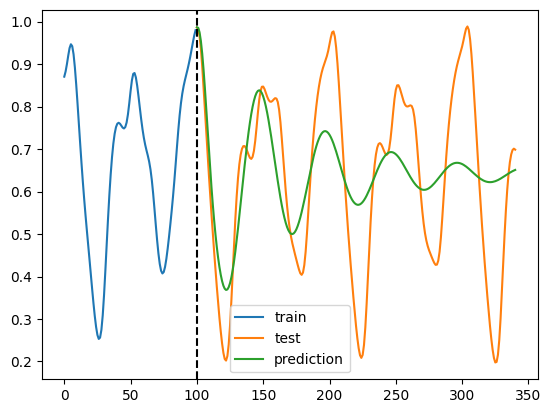

10 steps horizon - rmse = 0.039
50 steps horizon - rmse = 0.0891
100 steps horizon - rmse = 0.102
200 steps horizon - rmse = 0.1413
241 steps horizon - rmse = 0.1664


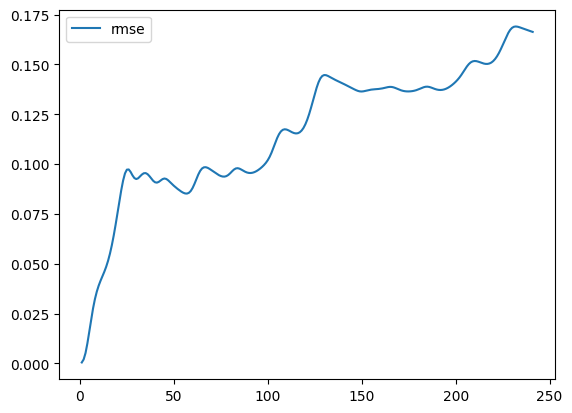


******************************

DATASET.TEMPERATURE


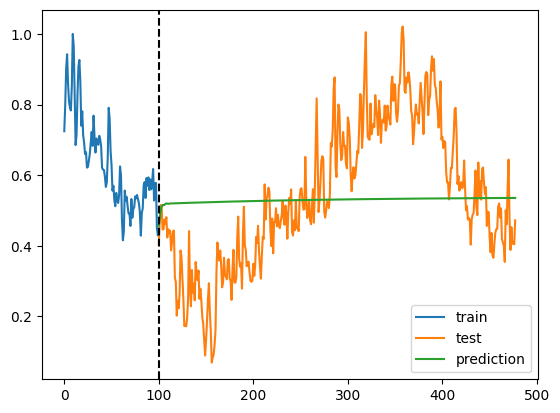

10 steps horizon - rmse = 0.053
50 steps horizon - rmse = 0.2248
100 steps horizon - rmse = 0.2323
200 steps horizon - rmse = 0.183
300 steps horizon - rmse = 0.2166
378 steps horizon - rmse = 0.1982


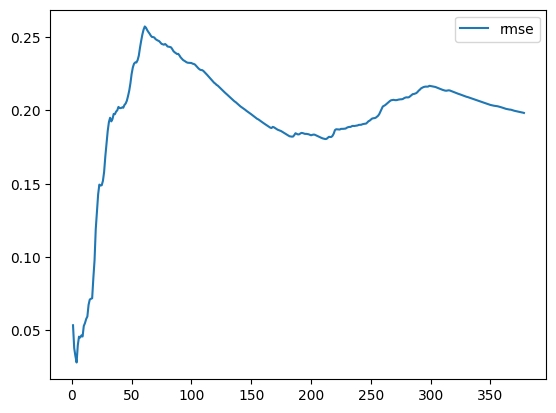


******************************



In [14]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

# Forecasting with TFT

## Train model

In [20]:
MODEL_DIR = Path().cwd().parent / "models/tft"

model_electricity = predictors.TFTPredictor().load(str(MODEL_DIR / "electricity08:06:31"))
model_sunspots = predictors.TFTPredictor().load(str(MODEL_DIR / "sunspots01:52:41"))
model_mackey_glass = predictors.TFTPredictor().load(str(MODEL_DIR / "mackey_glass08:16:47"))
model_temperature = predictors.TFTPredictor().load(str(MODEL_DIR / "temperature08:33:50"))

models = {
    "electricity": model_electricity,
    "sunspots": model_sunspots,
    "mackey_glass": model_mackey_glass,
    "temperature": model_temperature,
}

## Evaluate model

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:06<00:00,  6.82s/it]
DATASET.SUNSPOTS


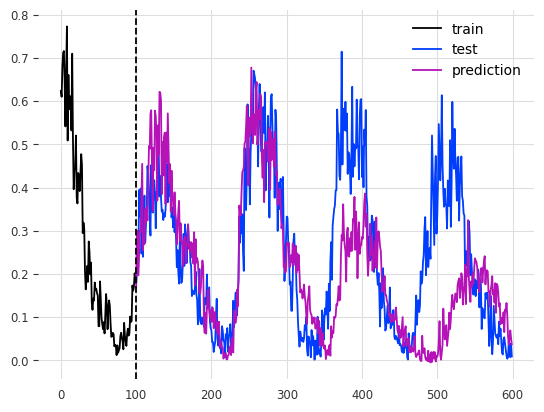

10 steps horizon - rmse = 0.0947
50 steps horizon - rmse = 0.1231
100 steps horizon - rmse = 0.1026
200 steps horizon - rmse = 0.0934
300 steps horizon - rmse = 0.1309
653 steps horizon - rmse = 0.1626


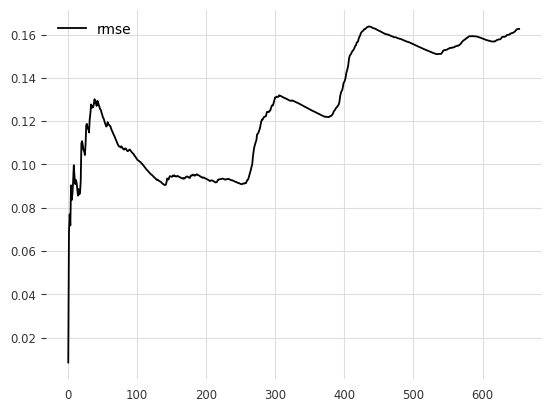

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(



******************************

Predicting DataLoader 0: 100%|██████████| 1/1 [00:09<00:00,  9.98s/it]
DATASET.ELECTRICITY


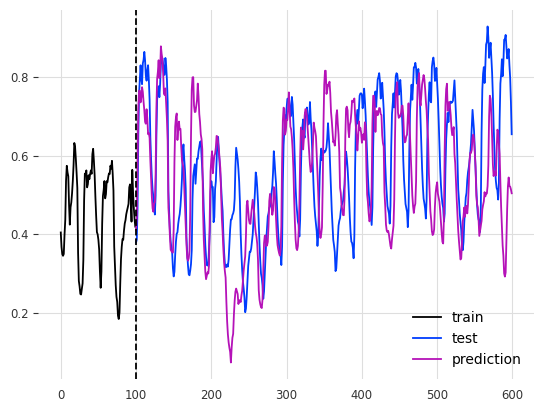

10 steps horizon - rmse = 0.0649
50 steps horizon - rmse = 0.074
100 steps horizon - rmse = 0.1288
200 steps horizon - rmse = 0.1407
300 steps horizon - rmse = 0.1499
1000 steps horizon - rmse = 0.1846
1000 steps horizon - rmse = 0.1846


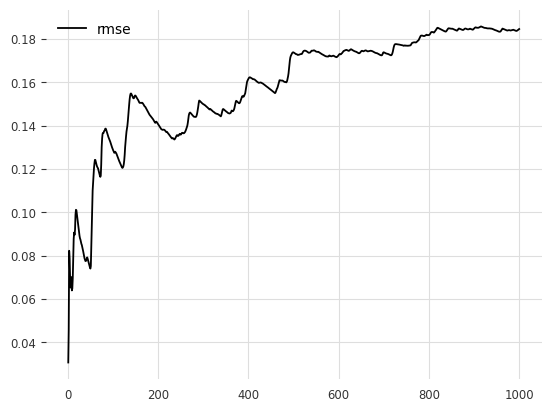

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(



******************************

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
DATASET.MACKEY_GLASS


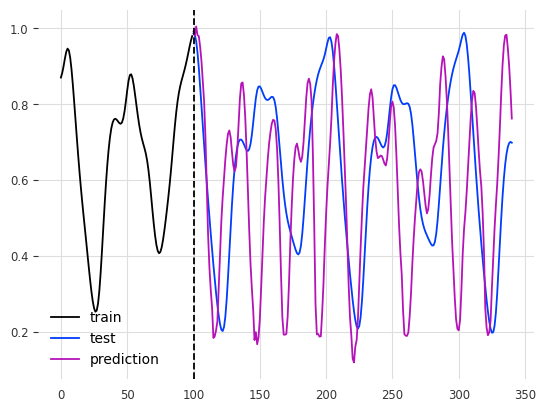

10 steps horizon - rmse = 0.0822
50 steps horizon - rmse = 0.2669
100 steps horizon - rmse = 0.3084
200 steps horizon - rmse = 0.29
241 steps horizon - rmse = 0.2936


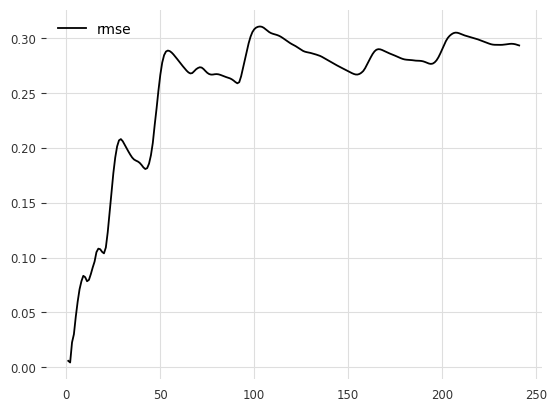

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(



******************************

Predicting DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]
DATASET.TEMPERATURE


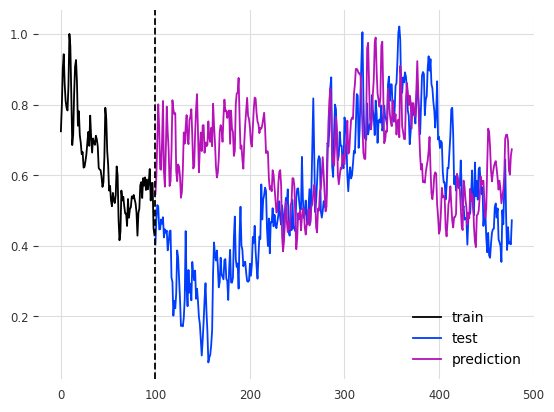

10 steps horizon - rmse = 0.2196
50 steps horizon - rmse = 0.3852
100 steps horizon - rmse = 0.4128
200 steps horizon - rmse = 0.3142
300 steps horizon - rmse = 0.2717
378 steps horizon - rmse = 0.2518


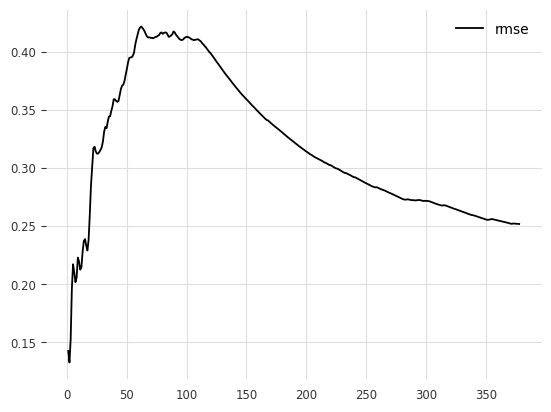


******************************



In [21]:

datasets = [sunspots, electricity, mackey_glass, temperature]
for dataset in datasets:
    y_val = dataset.y_val.flatten()
    model = models[dataset.name]
    horizon = min(10 * model.input_chunk_length, y_val.shape[0])
    y_pred = model.forecast(horizon)

    print(dataset.name)

    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON], y_pred[:MAX_PLOT_HORIZON].flatten())
    # plot_predictions(dataset.y_train[-model.input_chunk_length: ].flatten(), y_val[:horizon], y_pred.flatten())
    plt.show()

    calculate_rmse(y_val[:horizon], y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

# Forecasting with XGBoost

## Train model

In [15]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        }
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        }
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        }
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 month lag": "30 days",
            "15 days lag": "15 days"
        } 
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31564, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(960, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.TEMPERATURE
(1509, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


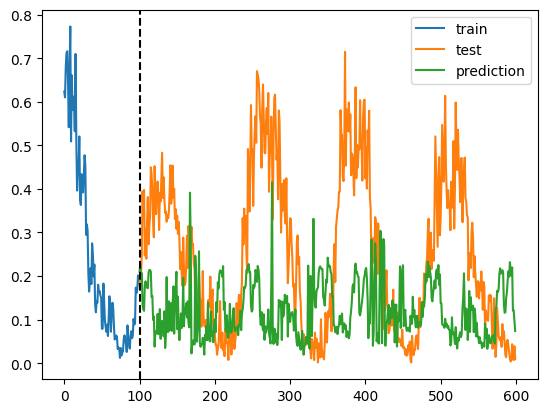

10 steps horizon - rmse = 0.1464
50 steps horizon - rmse = 0.2483
100 steps horizon - rmse = 0.1986
200 steps horizon - rmse = 0.246
300 steps horizon - rmse = 0.25
653 steps horizon - rmse = 0.2057


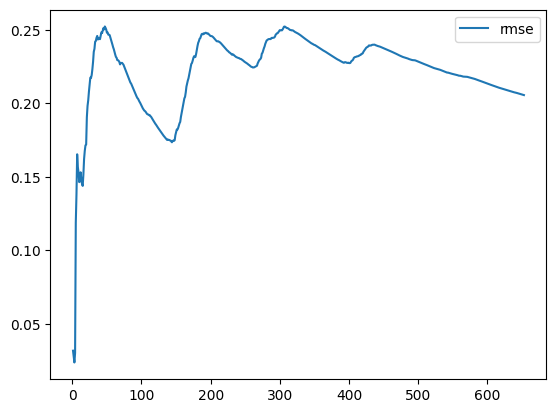


******************************



/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


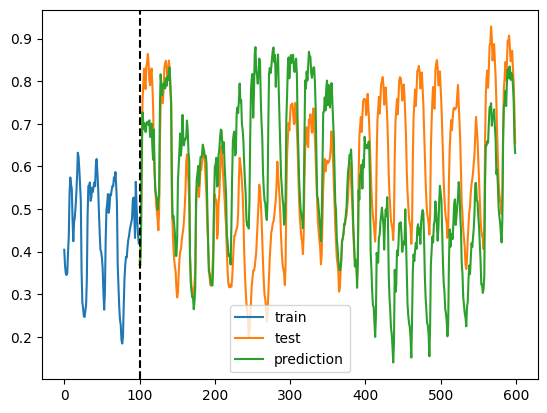

10 steps horizon - rmse = 0.0839
50 steps horizon - rmse = 0.0767
100 steps horizon - rmse = 0.0975
200 steps horizon - rmse = 0.1935
300 steps horizon - rmse = 0.1682
1000 steps horizon - rmse = 0.1509
7891 steps horizon - rmse = 0.1318


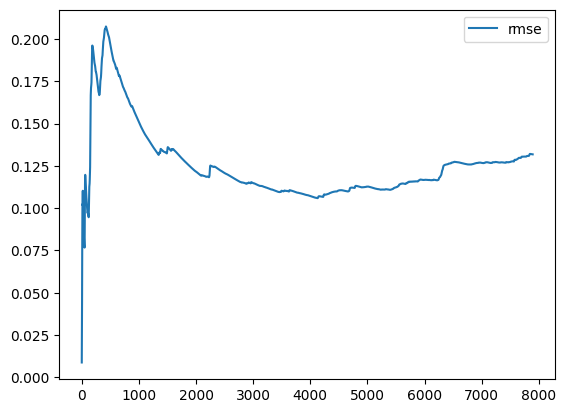


******************************

DATASET.MACKEY_GLASS


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


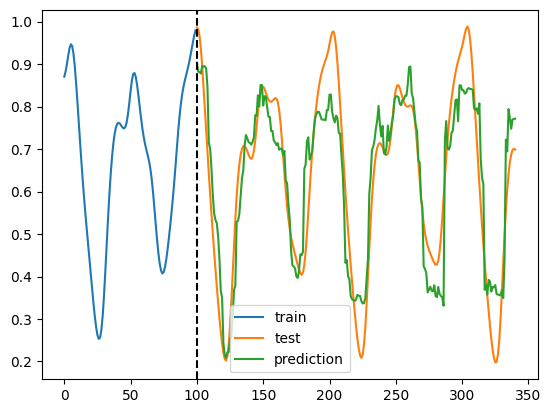

10 steps horizon - rmse = 0.0949
50 steps horizon - rmse = 0.083
100 steps horizon - rmse = 0.0854
200 steps horizon - rmse = 0.0873
241 steps horizon - rmse = 0.0918


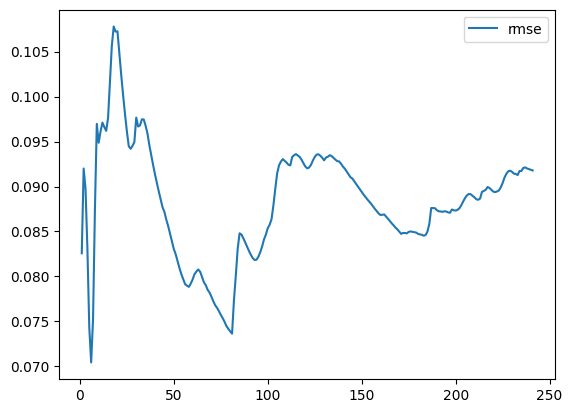


******************************

DATASET.TEMPERATURE


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:286: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


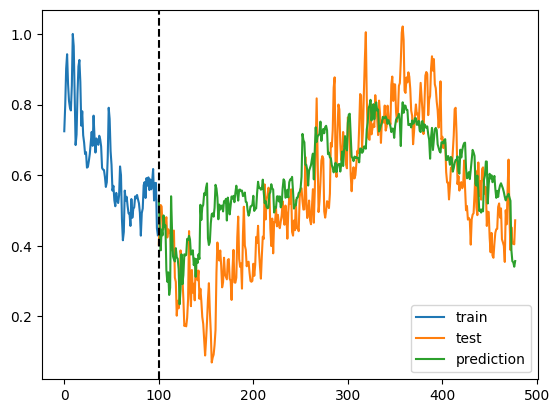

10 steps horizon - rmse = 0.088
50 steps horizon - rmse = 0.1588
100 steps horizon - rmse = 0.199
200 steps horizon - rmse = 0.1654
300 steps horizon - rmse = 0.1488
378 steps horizon - rmse = 0.1415


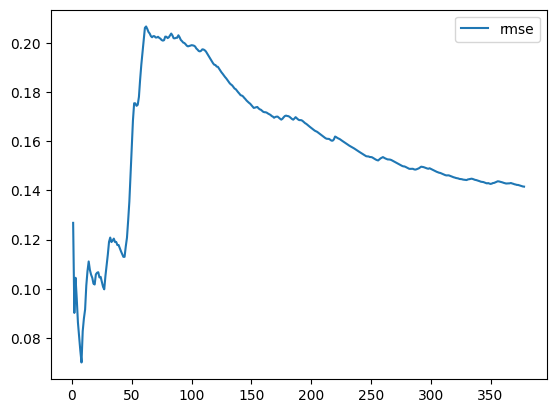


******************************



In [16]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()
    # print(y_pred.shape, df_val.shape)
    # plt.plot(y_pred, label="pred")
    # plt.plot(y_val, label="val")
    # plt.legend()
    # plt.show()

# Forecasting with LightGBM

## Train model

In [17]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 1000,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        }
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        }
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        }
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 months lag": "30 days",
            "15 days lag": "15 days"
        } 
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31564, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(960, 2)
DATASET.TEMPERATURE
(1509, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)
/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


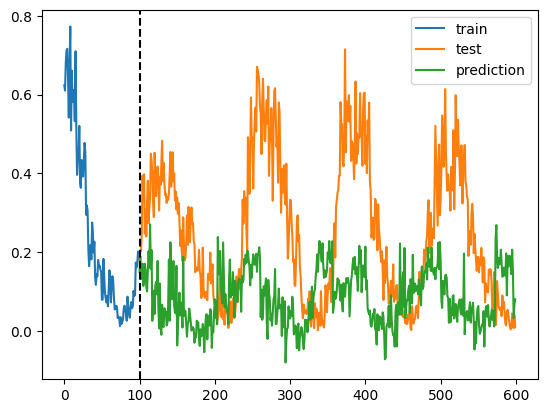

10 steps horizon - rmse = 0.1525
50 steps horizon - rmse = 0.2702
100 steps horizon - rmse = 0.2325
200 steps horizon - rmse = 0.2725
300 steps horizon - rmse = 0.268
653 steps horizon - rmse = 0.2242


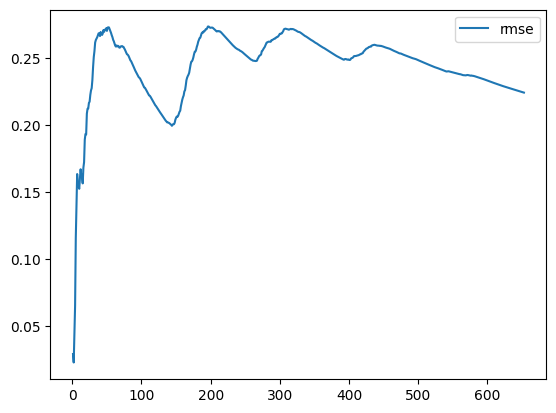


******************************



/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


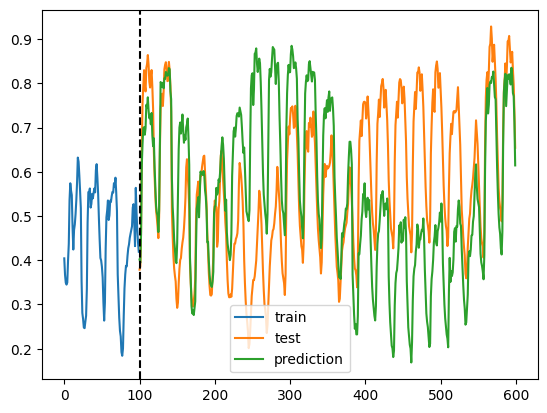

10 steps horizon - rmse = 0.079
50 steps horizon - rmse = 0.0618
100 steps horizon - rmse = 0.1013
200 steps horizon - rmse = 0.1982
300 steps horizon - rmse = 0.1756
1000 steps horizon - rmse = 0.1479
7891 steps horizon - rmse = 0.1287


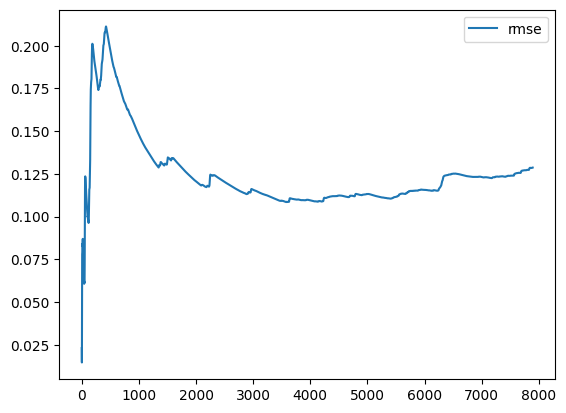


******************************

DATASET.MACKEY_GLASS


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


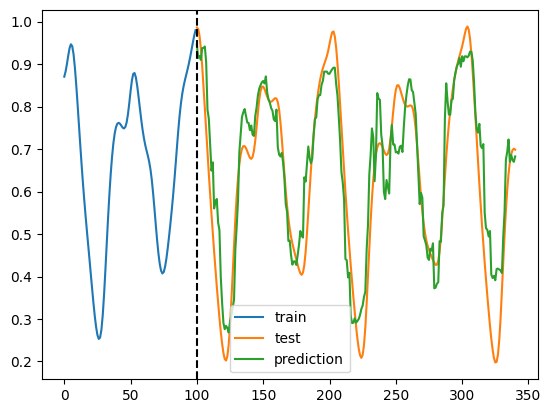

10 steps horizon - rmse = 0.0966
50 steps horizon - rmse = 0.0948
100 steps horizon - rmse = 0.0815
200 steps horizon - rmse = 0.0817
241 steps horizon - rmse = 0.0892


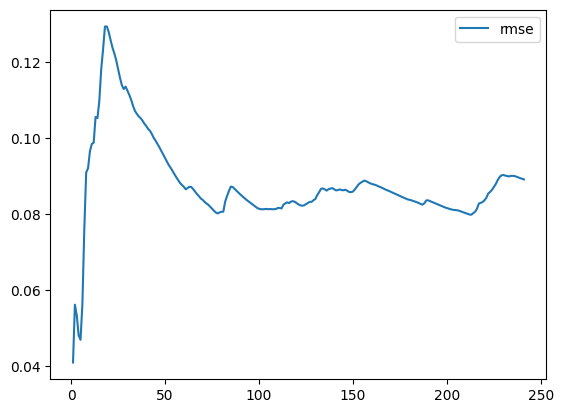


******************************

DATASET.TEMPERATURE


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:373: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


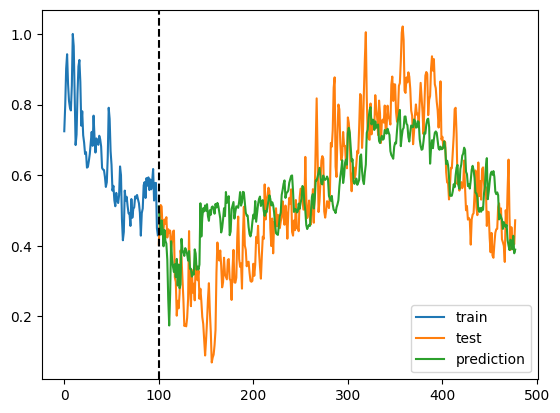

10 steps horizon - rmse = 0.0596
50 steps horizon - rmse = 0.1487
100 steps horizon - rmse = 0.1847
200 steps horizon - rmse = 0.1517
300 steps horizon - rmse = 0.1445
378 steps horizon - rmse = 0.1371


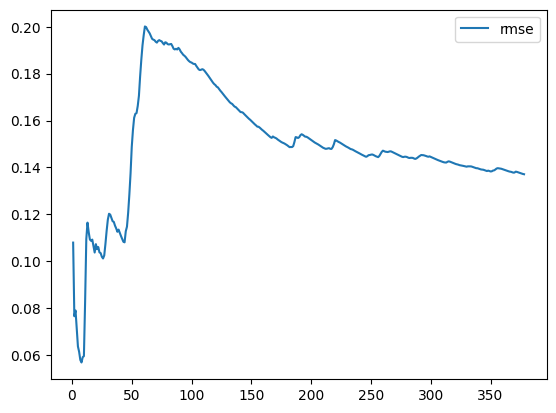


******************************



In [18]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    # print(y_pred.shape, df_val.shape)
    # plt.plot(y_pred, label="pred")
    # plt.plot(y_val, label="val")
    # plt.legend()
    # plt.show()

# Forecasting with ESN

## Train model

In [22]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
for dataset in datasets:
    print(dataset.name)
    X_train, y_train = dataset.X_train, dataset.y_train
    print(X_train.shape, y_train.shape)
    model = predictors.ESNPredictor(input_size=1, hidden_size=1000, output_size=1, num_layers=4)
    model.fit(X_train, y_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2611, 1) (2611, 1)


RuntimeError: expected scalar type Double but found Float

## Evaluate model

(653, 1) (653, 1)


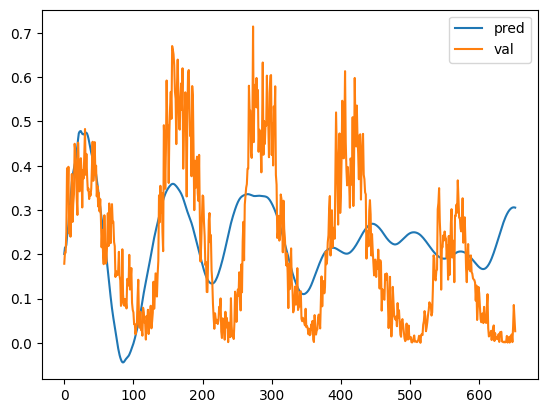

(7891, 1) (7891, 1)


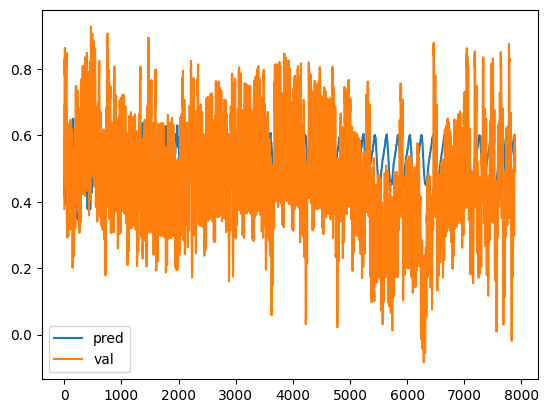

(241, 1) (241, 1)


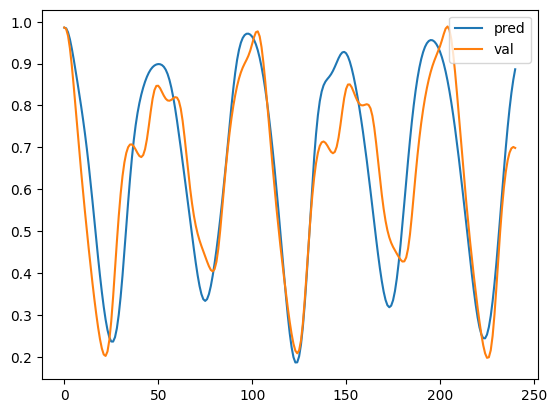

In [ ]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()
    # print(y_pred.shape, y_val.shape)
    # plt.plot(y_pred, label="pred")
    # plt.plot(y_val, label="val")
    # plt.legend()
    # plt.show()